# TABLE OF CONTENTS
* [Introduction](#Introduction)
* [Exploring COCO Dataset](#Exploring-COCO-Dataset)
* [Image caption generator](#Image-caption-generator)
* [Build SSD300](#Preprocess-and-caching-the-features-extracted-from-SSD300)
* [Make a Data Generator](#Make-a-Data-Generator)
* [CNN and LSTM architecture](#Model-Architechture)
* [Train and test the model](#Train-and-test-the-model)
* [HOG feature descriptor](#HOG-feature-descriptor)

# Introduction

> Image captioning is the task of generating textual descriptions of a given image, requiring  techniques of computer vision and natural language processing.

It is a popular research area of Artificial Intelligence that deals with image understanding and a language description for that image. Generating well-formed sentences requires both syntactic and semantic understanding of the language. Being able to describe the content of an image using accurately formed sentences is a very challenging task, but it could also have a great impact, by helping visually impaired people better understand the content of images.  [source](https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/) 

Here, I have used [COCO Dataset 2017](https://cocodataset.org/#download) which contains **12 different types of categories** and among them it has **80 types of sub-categories**. Each sub categories contain list of images and five captions to each image.

In [1]:
!pip install pycocotools

from pycocotools.coco import COCO # COCO python library
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

import random
import string

import cv2
import os
from pickle import dump, load
import json

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# from keras.layers.merge import add
from keras.layers import concatenate

from tensorflow.keras.models import Model, load_model

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373756 sha256=131845761bb1b0270aa86ed6d8fa30d631efc73464ed1c82df33f416ced0396a
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Prepare Dataset

1. Add COCO dataset share to your google drive account via this link (login if necessary): https://drive.google.com/drive/folders/1EVsLBRwT2njNWOrmBAhDHvvB8qrd9pXT?usp=sharing
2. Now COCO directory should be in your 'Shared with me' section of google drive
3. Create shortcut of COCO share to your drive, right click and select 'Add Shortcut to drive', choose root of 'My Drive'. Now you should see COCO directory under 'My Drive' section.



# Exploring COCO Dataset

#### Initialize COCO class and operate instances_train2017.json
Remember to change the path link

In [2]:
coco=COCO("../input/cocods/annotations_trainval2017/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=21.34s)
creating index...
index created!


#### Find Categories

In [3]:
cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Number of main categories: ", len(maincategories))
print("List of main categories: ", maincategories)

Number of main categories:  12
List of main categories:  ['furniture', 'person', 'animal', 'food', 'electronic', 'kitchen', 'indoor', 'appliance', 'sports', 'outdoor', 'vehicle', 'accessory']


#### Find Sub Categories

In [4]:
subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)

Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


#### Find Sub categories with its corresponding IDs

In [5]:
catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categories with IDs :",subcategories_Ids)

Sub categories with IDs : {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, 'laptop': 73, 'mouse': 74, 'remote': 75, 'keyboard': 76, 'c

#### Find total images with each sub categories

In [6]:
subcategories_imageIds = dict()

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    img = []
    for j in imgIds: 
        img.append(j)
    subcategories_imageIds[subcategories[i]] = img
    
print("Sub categories with Image IDs :",len(subcategories_imageIds))

Sub categories with Image IDs : 80


In [7]:
length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Total images in each sub categories: ", length_dict)

Total images in each sub categories:  {'person': 64115, 'bicycle': 3252, 'car': 12251, 'motorcycle': 3502, 'airplane': 2986, 'bus': 3952, 'train': 3588, 'truck': 6127, 'boat': 3025, 'traffic light': 4139, 'fire hydrant': 1711, 'stop sign': 1734, 'parking meter': 705, 'bench': 5570, 'bird': 3237, 'cat': 4114, 'dog': 4385, 'horse': 2941, 'sheep': 1529, 'cow': 1968, 'elephant': 2143, 'bear': 960, 'zebra': 1916, 'giraffe': 2546, 'backpack': 5528, 'umbrella': 3968, 'handbag': 6841, 'tie': 3810, 'suitcase': 2402, 'frisbee': 2184, 'skis': 3082, 'snowboard': 1654, 'sports ball': 4262, 'kite': 2261, 'baseball bat': 2506, 'baseball glove': 2629, 'skateboard': 3476, 'surfboard': 3486, 'tennis racket': 3394, 'bottle': 8501, 'wine glass': 2533, 'cup': 9189, 'fork': 3555, 'knife': 4326, 'spoon': 3529, 'bowl': 7111, 'banana': 2243, 'apple': 1586, 'sandwich': 2365, 'orange': 1699, 'broccoli': 1939, 'carrot': 1683, 'hot dog': 1222, 'pizza': 3166, 'donut': 1523, 'cake': 2925, 'chair': 12774, 'couch': 44

In [8]:
subcategories_imageIds['donut'][:10]

[24577, 73733, 475142, 466960, 393243, 32801, 352295, 548906, 335922, 335928]

Here, I have selected category **donut** for accomplishing image caption generator project.

In [9]:
train_cats = subcategories_imageIds['donut']
imgIdss = coco.getImgIds(imgIds = train_cats)
print("Total Images: ", len(imgIdss))

Total Images:  1523


#### Load some of the random images

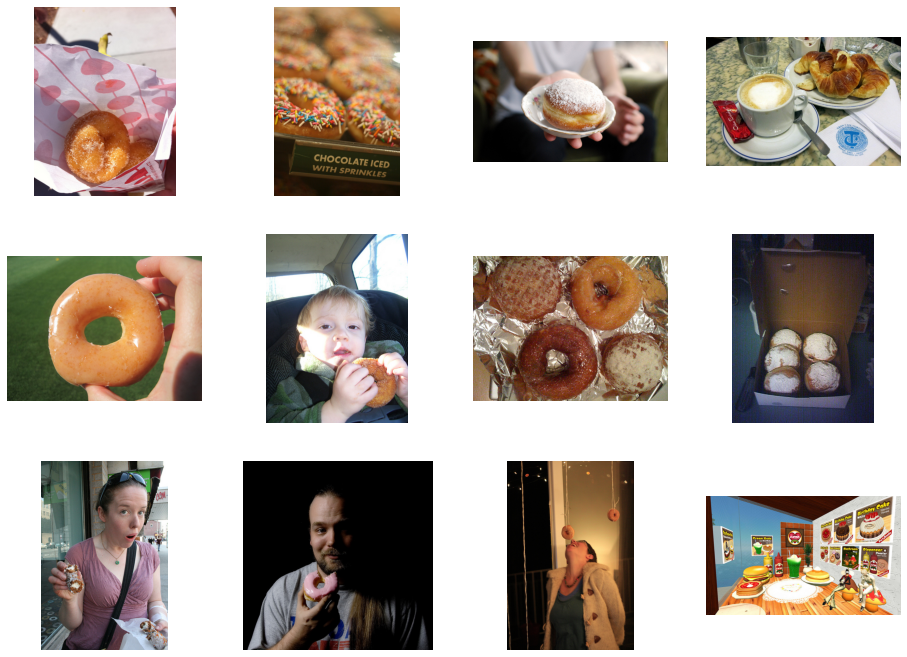

In [10]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

#### Load some of the random images with segmented objects inside them 

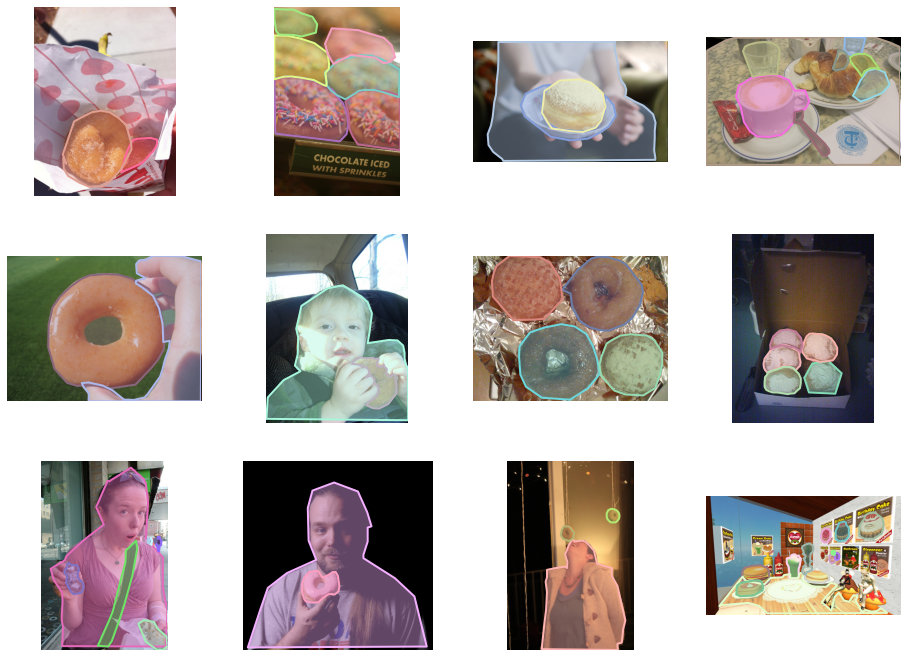

In [11]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    # print(anns)
    coco.showAnns(anns)
    

plt.show()

#### Load images with keypoints objects

In [12]:
annFile = "../input/cocods/annotations_trainval2017/annotations/person_keypoints_train2017.json"
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=9.54s)
creating index...
index created!


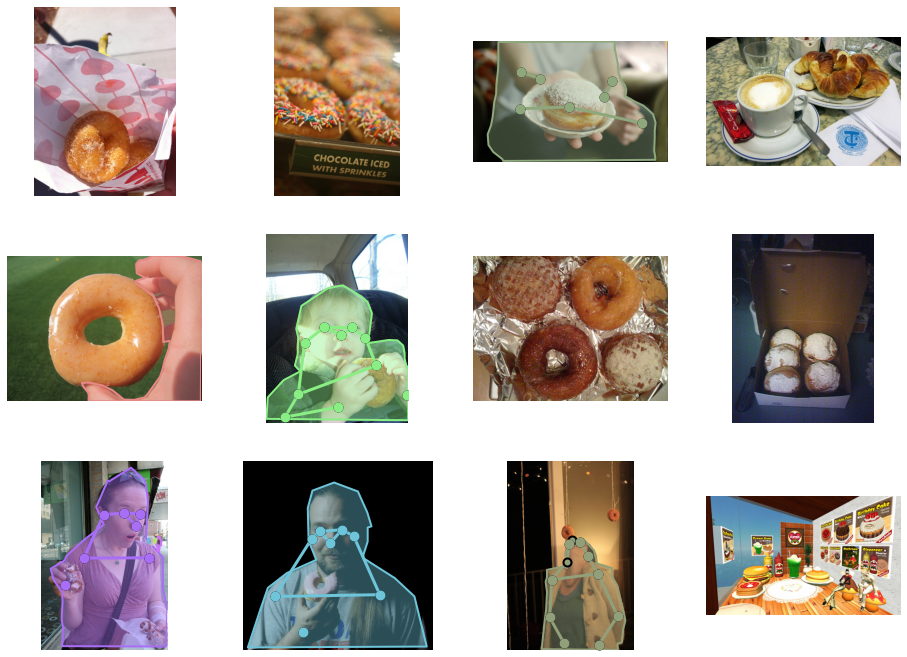

In [13]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    coco_kps.showAnns(anns)
    

plt.show()

#### Load images with respective captions

In [14]:
annFile = "../input/cocods/annotations_trainval2017/annotations/captions_train2017.json"
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=1.68s)
creating index...
index created!


There are two sugar donuts left in the bag. 
A small pastry in a paper bag container.
A bag filled with sugary donuts stacked on top of each other.
Two donuts in a red and white paper bag.
a pastry in a paper bag with red dot designs on it.


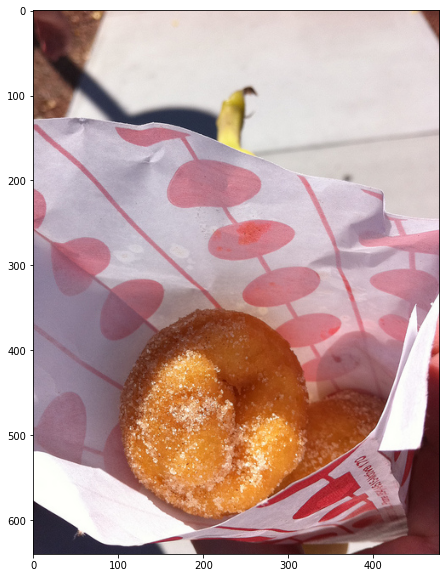

In [15]:
img = coco.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

A number of decorated donuts on a table
A tray of donuts labeled "Chocolate Iced With Sprinkles"
a close up of a tray of donuts with sprinkles
A sign showing that its a tray of chocolate sprinkle doughnuts
Chocolate iced donuts with sprinkles are on a tray.


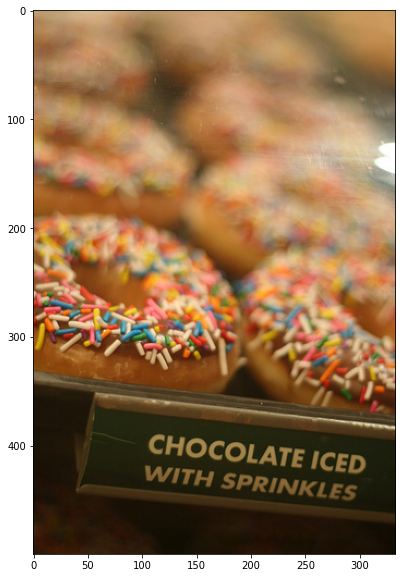

In [16]:
img = coco.loadImgs(next_pix[1])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

a woman eating donuts from strings on a porch.
A woman trying to eat a donut tied on a string
A woman trying to bite a doughnut hanging on a string from the ceiling.
A woman laughing and trying to bite a doughnut hanging by a string.
a woman in a white jacket and two donuts hanging 


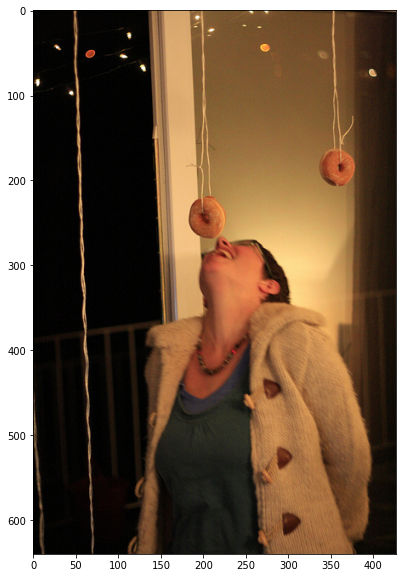

In [17]:
img = coco.loadImgs(next_pix[10])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

# Image caption generator
#### Here I have taken "Donut" images and captions only.


In [18]:
print("Total images for training: ", len(imgIdss))

Total images for training:  1523


# Prepare Dataset 

#### Group all captions together having the same image and store them in dict.

In [39]:
dataset = dict()
imgcaptions = []

for imgid in imgIdss[:]:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:
        
        # Remove punctuation
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        
        # Replace - to blank
        cap = cap.replace("-"," ")
        
        # Split string into word list and Convert each word into lower case
        cap = cap.split()
        cap = [word.lower() for word in cap]
        
        # join word list into sentence and <start> and <end> tag to each sentence which helps 
        # LSTM encoder-decoder model while training.
        
        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)
        
    dataset[img['coco_url']] = imgcaptions 
    
    
print("Length of Dataset: ",len(dataset))

Length of Dataset:  1523


In [40]:
print(imgIdss[1])

525459


In [41]:
print (list(dataset.keys())[1])
dataset[str(list(dataset.keys())[1])]

http://images.cocodataset.org/train2017/000000525459.jpg


['<start> a number of decorated donuts on a table <end>',
 '<start> a tray of donuts labeled chocolate iced with sprinkles <end>',
 '<start> a close up of a tray of donuts with sprinkles <end>',
 '<start> a sign showing that its a tray of chocolate sprinkle doughnuts <end>',
 '<start> chocolate iced donuts with sprinkles are on a tray <end>']

# Preprocess and tokenize the captions

In [42]:
from itertools import chain
flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Vocabulary length: ", total_words)
print("donut ID: ", tokenizer.word_index['donut'])

Vocabulary length:  2968
donut ID:  11


# Preprocess and caching the features extracted from SSD300

I will use SSD300 to classify each image. I will extract features from the last convolutional layer.

Here, the SSD300 model takes **299 x 299 x 3** image size as input. We will remove the last classification layer and get the **2048 feature vector**.

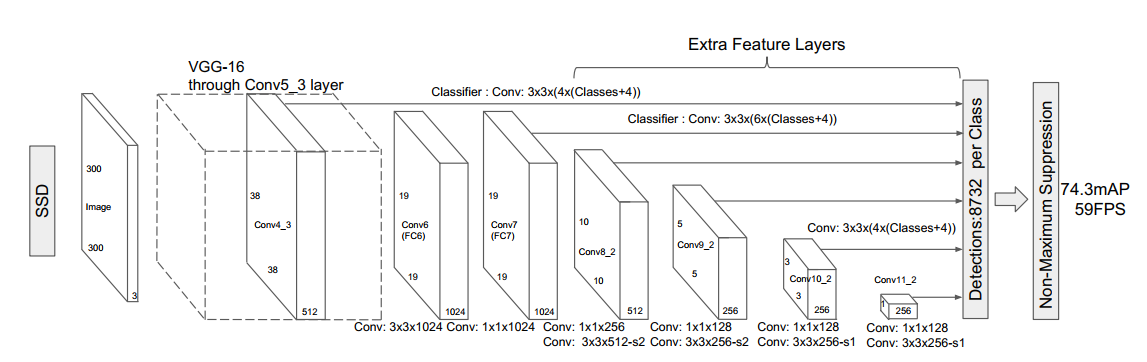

The SSD approach is based on a feed-forward convolutional network that produces
a fixed-size collection of bounding boxes and scores for the presence of object class
instances in those boxes, followed by a non-maximum suppression step to produce the
final detections

Multi-scale feature maps for detection: add convolutional feature layers to the end of the truncated base network. These layers decrease in size progressively and allow predictions of detections at multiple scales

SSD has two components: a backbone model and SSD head. Backbone model usually is a pre-trained image classification network as a feature extractor. This is typically a network like ResNet trained on ImageNet from which the final fully connected classification layer has been removed. We are thus left with a deep neural network that is able to extract semantic meaning from the input image while preserving the spatial structure of the image albeit at a lower resolution. For ResNet34, the backbone results in a 256 7x7 feature maps for an input image. We will explain what feature and feature map are later on. The SSD head is just one or more convolutional layers added to this backbone and the outputs are interpreted as the bounding boxes and classes of objects in the spatial location of the final layers activations.

In [43]:
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import concatenate
from keras.layers import Reshape
from keras.layers import ZeroPadding2D
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D


def ssd300_body(x):
    
    source_layers = []

    # Block 1
    x = Conv2D(64, 3, strides=1, padding='same', name='conv1_1', activation='relu')(x)
    x = Conv2D(64, 3, strides=1, padding='same', name='conv1_2', activation='relu')(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same', name='pool1')(x)
    # Block 2
    x = Conv2D(128, 3, strides=1, padding='same', name='conv2_1', activation='relu')(x)
    x = Conv2D(128, 3, strides=1, padding='same', name='conv2_2', activation='relu')(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same', name='pool2')(x)
    # Block 3
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_1', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_2', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_3', activation='relu')(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same', name='pool3')(x)
    # Block 4
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_1', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_2', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_3', activation='relu')(x)
    source_layers.append(x)
    x = MaxPool2D(pool_size=2, strides=2, padding='same', name='pool4')(x)
    # Block 5
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_1', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_2', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_3', activation='relu')(x)
    x = MaxPool2D(pool_size=3, strides=1, padding='same', name='pool5')(x)
    # FC6
    x = Conv2D(1024, 3, strides=1, dilation_rate=(6, 6), padding='same', name='fc6', activation='relu')(x)
    # FC7
    x = Conv2D(1024, 1, strides=1, padding='same', name='fc7', activation='relu')(x)
    source_layers.append(x)
    # Block 6
    x = Conv2D(256, 1, strides=1, padding='same', name='conv6_1', activation='relu')(x)
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(512, 3, strides=2, padding='valid', name='conv6_2', activation='relu')(x)
    source_layers.append(x)
    # Block 7
    x = Conv2D(128, 1, strides=1, padding='same', name='conv7_1', activation='relu')(x)
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(256, 3, strides=2, padding='valid', name='conv7_2', activation='relu')(x)
    source_layers.append(x)
    # Block 8
    x = Conv2D(128, 1, strides=1, padding='same', name='conv8_1', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='valid', name='conv8_2', activation='relu')(x)
    source_layers.append(x)
    # Block 9
    x = Conv2D(128, 1, strides=1, padding='same', name='conv9_1', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='valid', name='conv9_2', activation='relu')(x)
    source_layers.append(x)
    
    return source_layers

def multibox_head(source_layers, num_priors):

    feature = []
    for i in range(len(source_layers)):
        x = source_layers[i]
        name = x.name.split('/')[0]
            
        # confidence
        name1 = name + '_feature'
        x1 = Conv2D(2048, 3, padding='same', name=name1)(x)
        x1 = Flatten(name=name1+'_flat')(x1)
        feature.append(x1)
        
    feature = concatenate(feature, axis=1, name='feature')
    feature = Reshape((-1, 2048), name='feature_logits')(feature)
    feature = GlobalAveragePooling1D(data_format='channels_last')(feature)
    
    return feature
        
def SSD300(input_shape=(299, 299, 3)):
    
    x = input_tensor = Input(shape=input_shape)
    source_layers = ssd300_body(x)
    
    # Add multibox head for classification and regression
    num_priors = [4, 6, 6, 6, 4, 4]

    output_tensor = multibox_head(source_layers, num_priors)
    model = Model(input_tensor, output_tensor)
    
    return model
body = ssd300_body(x = Input(shape=(299,299,3)))
print ("The output of the SSD300_body\n",body)
SSD300_model = SSD300()
SSD300_model.summary()
print (SSD300_model)

The output of the SSD300_body
 [<KerasTensor: shape=(None, 38, 38, 512) dtype=float32 (created by layer 'conv4_3')>, <KerasTensor: shape=(None, 19, 19, 1024) dtype=float32 (created by layer 'fc7')>, <KerasTensor: shape=(None, 10, 10, 512) dtype=float32 (created by layer 'conv6_2')>, <KerasTensor: shape=(None, 5, 5, 256) dtype=float32 (created by layer 'conv7_2')>, <KerasTensor: shape=(None, 3, 3, 256) dtype=float32 (created by layer 'conv8_2')>, <KerasTensor: shape=(None, 1, 1, 256) dtype=float32 (created by layer 'conv9_2')>]
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 299, 299, 64) 1

Now is some image preprocessing to feed into the model
1. Grayscale the image
2. Resize image to 299x299
3. Expand Dimension
4. Normalize image to 0-1

In [44]:
image_features = {}
for img in tqdm(dataset.keys()):
    image = io.imread(img)
    if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    # Resize each image size 299 x 299
    image = cv2.resize(image,(299,299))
    image = np.expand_dims(image, axis=0)
    
    # Normalize image pixels
    image = image/127.5
    image = image - 1.0

    # Extract features from image
    feature = SSD300_model.predict(image)
    image_features[img] = feature
    
print("Image features length: ", len(image_features))

  0%|          | 0/1523 [00:00<?, ?it/s]

Image features length:  1523


In [45]:
print ("Shape of the output feature\n",image_features[str(list(dataset.keys())[1])].shape)
print ("Features of the output\n",image_features[str(list(dataset.keys())[1])])

Shape of the output feature
 (1, 2048)
Features of the output
 [[ 3.3414431e-03  1.5170046e-04  1.4111014e-03 ... -5.3766440e-04
   9.9258112e-05  1.5448251e-04]]


Here, I have found the max_length among the captions which will help to pad each caption with the same length.

In [46]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(dataset)
max_length

42

# Make a Data Generator

We have to train our model on a lot of images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of images is not possible to hold into memory so we will be using a generator method that will yield batches.

**The generator will yield the input and output sequence.**

##### For example:

The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.


In [47]:
#create input-output sequence pairs from the image description.

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
            
    return np.array(X1), np.array(X2), np.array(y)


# Define CNN-LSTM Model

#### CNN (Convolution Neural Network)

Technically, deep learning CNN models to train and test, each input image will pass it through a series of convolution layers with filters (Kernals), Pooling, fully connected layers (FC) and apply Softmax function to classify an object with probabilistic values between 0 and 1.


#### [Click here](https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/) to know more about CNN.

<br>

#### LSTM (Long short-term memory)


Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more. LSTMs are a complex area of deep learning


#### [Click here](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/) to know more about LSTM.


# Model Architechture 

### CNN-LSTM model:

- CNN is used for extracting features from the image. We will use the pre-trained model Xception.
- LSTM will use the information from CNN to help generate a description of the image.


### Model structure

* The feature extracted from the image has a size of 2048, with a dense layer, we will reduce the dimensions to 256 nodes.<br> 
* An embedding layer will handle the text input,followed by the LSTM layer.
<br>
* Then By merging the output from the above two layers, we will process by the dense layer to make the final prediction. The final layer will contain the number of nodes equal to our vocabulary size.

In [48]:
# define the captioning model
def define_model(total_words, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    # decoder1 = add([fe2, se3])
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())

    return model


# Train and test the model

In [49]:
# train our model
print('Dataset: ', len(dataset))
print('Descriptions: train=', len(dataset))
print('Photos: train=', len(image_features))
print('Vocabulary Size:', total_words)
print('Description Length: ', max_length)

model = define_model(total_words, max_length)
epochs = 10
steps = len(dataset)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./model_{epoch:02d}.h5', 
                                    save_freq='epoch',
                                    monitor='loss',
                                    mode='min',
                                    save_best_only=True,
                                    period = 3),

# for i in range(epochs):
generator = data_generator(dataset, image_features, tokenizer, max_length)
history = model.fit(generator, epochs=epochs, steps_per_epoch= steps, verbose=1,callbacks = checkpoint)
model.save("./best_model.h5")
    

Dataset:  1523
Descriptions: train= 1523
Photos: train= 1523
Vocabulary Size: 2968
Description Length:  42
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 42, 256)      759808      input_8[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_7[0][0]      

dict_keys(['loss'])


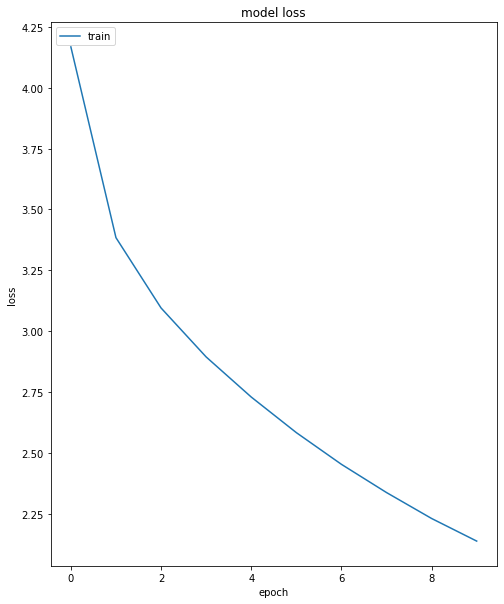

In [50]:
def plot_train (history):
    # list all data in history
    print(history.history.keys())

    # summarize history for loss

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
plot_train(history)




start a man eating a donut with a bite missing end
Feature
 [[ 4.7271475e-03  9.8545323e-05  2.1913769e-03 ... -4.1973821e-04
   1.7066472e-04  4.3288476e-04]]


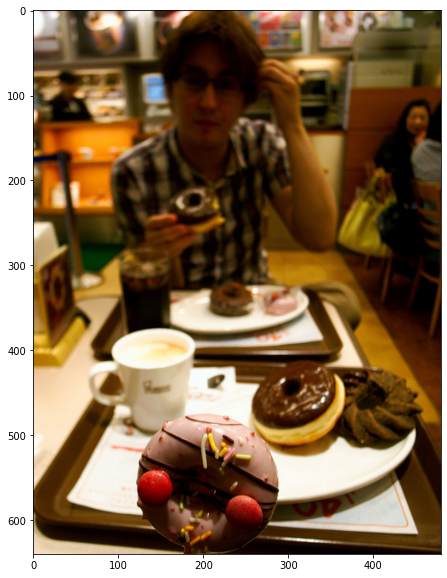

In [58]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


img_paths = ["../input/cocods/val2017/val2017/000000035682.jpg",
]

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text


#max_length = 46

model = load_model('/kaggle/working/best_model.h5')

photo = extract_features(img_paths[0], SSD300_model)
img = Image.open(img_paths[0])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
print ("Feature\n", photo)
plt.imshow(img)

# HOG feature descriptor

Histogram of Oriented Gradients, also known as HOG, is a feature descriptor like the Canny Edge Detector, SIFT (Scale Invariant and Feature Transform) . It is used in computer vision and image processing for the purpose of object detection

There are 5 basic steps to building a HOG vector for an image, including:

1. Preprocessing
2. Calculate gradient
3. Calculate feature vectors for each cell
4. Normalize blocks (blocks)
5. Calculate the HOG . vector

HOG will create the vector with dimension = Width x Height. Because the output feature of our SSD300 is 2048. So to easily compare the features, we need to resize the image before using HOG transform 

Image size:  (640, 480, 3)
hog_image
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          4.03577618  2.13514236 ...  2.68655792  1.42801198
   0.        ]
 [ 0.          2.13514236  4.03577618 ...  1.42801198  2.68655792
   0.        ]
 ...
 [ 0.          1.31712194  1.17117303 ... 15.58359241  4.69573021
   0.        ]
 [ 0.          1.17117303  1.31712194 ...  4.69573021 15.58359241
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


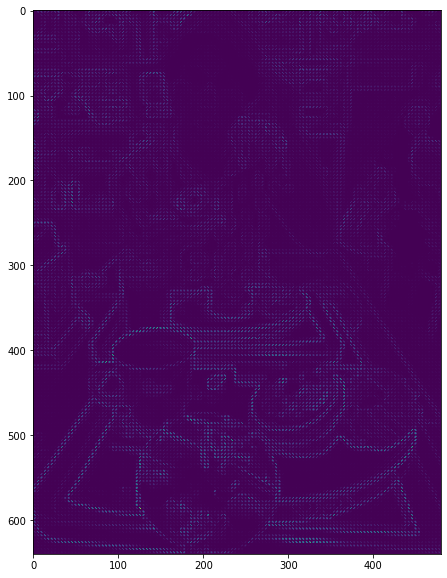

In [59]:
from skimage.feature import hog

def hog_images(crop):    
    image=crop[:,:,1]    
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(2, 2), visualize=True)    
    return hog_image

img_paths = ["../input/cocods/val2017/val2017/000000035682.jpg"]
im = cv2.imread(img_paths[0])
print ("Image size: ", im.shape)
hog_image = hog_images(im)
plt.imshow(hog_image)

print ('hog_image\n',hog_image)

The image shape is 640 x 840 = 537600 so we'll resize this image into 32 x 64 = 2048. Futhermore, we need to normalize the feature into 0-1 to compare

normalized hog_matrix
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.31230895 0.47924589 ... 0.27521336 0.29988929 0.        ]
 [0.         0.47924589 0.31230895 ... 0.29988929 0.27521336 0.        ]
 ...
 [0.         0.85309372 0.02761826 ... 0.61641638 0.28284206 0.        ]
 [0.         0.02761826 0.85309372 ... 0.28284206 0.61641638 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
hog_vec
 [0. 0. 0. ... 0. 0. 0.]


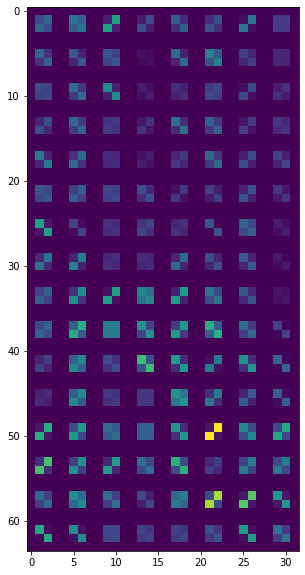

In [74]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

im = cv2.resize (im, (32,64))
hog_image = hog_images(im)
plt.imshow(hog_image)

hog_image = np.array(hog_image)
scaler.fit(hog_image)
scaler.transform(hog_image)
print ('normalized hog_matrix\n',scaler.transform(hog_image))
hog_vec = hog_image.flatten()

print ('hog_vec\n',hog_vec)

In [75]:
SSD_feature = extract_features(img_paths[0], SSD300_model)
scaler.fit(SSD_feature)
scaler.transform(SSD_feature)
print ('SSD_feature',SSD_feature)

SSD_feature [[ 4.7271475e-03  9.8545323e-05  2.1913769e-03 ... -4.1973821e-04
   1.7066472e-04  4.3288476e-04]]


Now we compare 2 vectors using the cosine similarity

The formula for calculating the cosine similarity is : Cos(x, y) = x . y / ||x|| * ||y|| .

The cosine similarity between two vectors is measured in 'θ'.
* If θ = 0°, the 'x' and 'y' vectors overlap, thus proving they are similar.
* If θ = 90°, the 'x' and 'y' vectors are dissimilar.

In [76]:
from numpy import dot
from numpy.linalg import norm

cos_sim = dot(SSD_feature, hog_vec)/(norm(SSD_feature)*norm(hog_vec))
print ("cos_sim",cos_sim)

cos_sim [0.02507498]


Because the Cosine similarity is quite small so the similariy is high

Another picture


original size (427, 640, 3)


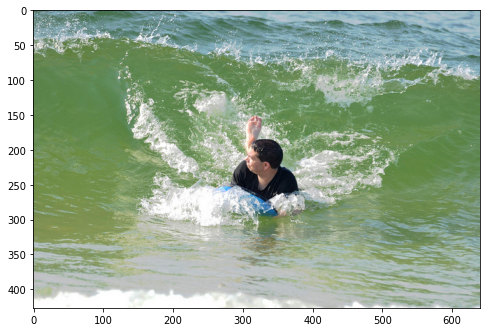

In [77]:
im2_path = '/kaggle/input/cocods/val2017/val2017/000000002261.jpg'
im2 = cv2.imread(im2_path)
print ('original size',im2.shape)
img2 = Image.open(im2_path)
plt.imshow(img2)

cos_sim2 [0.02018906]


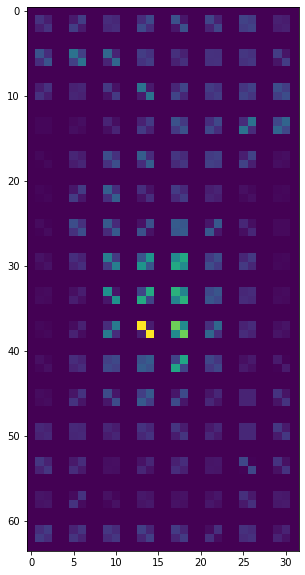

In [78]:
im2 =  cv2.resize(im2,(32,64))
hog_image2 = hog_images(im2)
plt.imshow(hog_image2)

hog_image2 = np.array(hog_image2)
scaler.fit(hog_image2)
scaler.transform(hog_image2)
hog_vec2 = hog_image2.flatten()

SSD_feature2 = extract_features(im2_path, SSD300_model)
scaler.fit(SSD_feature2)
scaler.transform(SSD_feature2)

cos_sim2 = dot(SSD_feature2, hog_vec2)/(norm(SSD_feature2)*norm(hog_vec2))
print ("cos_sim2",cos_sim2)

# **References**

1.   https://rupamgoyal12.medium.com/image-caption-generator-using-resnet50-and-lstm-model-a5b11f60cd23
2.   https://www.analyticsvidhya.com/blog/2020/11/create-your-own-image-caption-generator-using-keras/
3.   https://developers.arcgis.com/python/guide/how-ssd-works/
4.   https://github.com/thangnch/MiAI_SSD_TF2
5.   https://github.com/mvoelk/ssd_detectors/blob/master/ssd_model.py